In [ ]:

# cd drive/MyDrive/Colab\ Notebooks/


In [ ]:
# ls

# Imports + Setup

In [1]:
import os, re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt

In [2]:
# Set seeds for reproducibility
import random
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CUDA
torch.backends.cudnn.benchmark = False      # Disable auto-tuner that can introduce randomness

In [3]:
# File Mapping
h_map = {2: 0.0375, 3: 0.084, 6: 0.1575}
flux_map = {88: 25900, 78: 21250, 73: 19400}
abs_map = {0: 3, 92: 100}
surf_map = {0: 0.98, 1: 0.76}
pattern = r"h(\d+)_flux(\d+)_abs(\d+)(?:_[A-Za-z0-9]+)*_surf([01])(?:_[A-Za-z0-9]+)*[\s_]+(\d+)s\b"
# Depending on where u store the data files
# cd drive/MyDrive/Colab\ Notebooks/Theoretical_VTDP
DATA_DIR = "../../data/Theoretical_VTDP"
# DATA_DIR = "Theoretical_VTDP/"
DROP_COLS = ["TC_9_5", "TC_Bottom_rec_groove", "TC_wall_ins_ext", "TC_bottom_ins_groove", "Theoretical_Temps_11"]

# Utilities

In [5]:
def parse_filename_params(filename):
    m = re.search(pattern, filename)
    if not m:
        return None
    h_raw    = int(m.group(1))
    flux_raw = int(m.group(2))
    abs_raw  = int(m.group(3))
    surf_raw = int(m.group(4))
    t        = int(m.group(5))

    # keeping number if no entry exists
    h    = h_map.get(h_raw,    h_raw)
    flux = flux_map.get(flux_raw, flux_raw)
    abs_ = abs_map.get(abs_raw,  abs_raw)
    surf = surf_map.get(surf_raw)

    return h, flux, abs_, surf, t

def load_and_process_file(path, h, flux, abs_val, surf, min_time):
    df = pd.read_csv(path, encoding="utf-8-sig")
    df = df[df["Time"] >= min_time].copy()
    df.drop(columns=[col for col in df.columns if col in DROP_COLS or col.startswith("Depth_")], inplace=True)
    df["h"] = h
    df["flux"] = flux
    df["abs"] = abs_val
    df["surf"] = surf
    # df["filename"] = filename
    return df

# Load and Combine Data

In [6]:
dataframes = []
for fname in os.listdir(DATA_DIR):
    if not fname.endswith(".csv"):
        continue
    params = parse_filename_params(fname)
    if params is None or params[3] is None:
        print("Skipping:", fname)
        continue
    path = os.path.join(DATA_DIR, fname)
    df = load_and_process_file(path, *params)
    dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)
print(data.info())
print(data.head())


Skipping: h2_flux88_abs25_wr_surfParAdded_169s - Sheet1_processed.csv
Skipping: h2_flux88_abs25_wr_surfSimD_525s - Sheet1_processed.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66146 entries, 0 to 66145
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Time                  66146 non-null  int64  
 1   TC1_tip               66146 non-null  float64
 2   TC2                   66146 non-null  float64
 3   TC3                   66146 non-null  float64
 4   TC4                   66146 non-null  float64
 5   TC5                   66146 non-null  float64
 6   TC6                   66146 non-null  float64
 7   TC7                   66146 non-null  float64
 8   TC8                   66146 non-null  float64
 9   TC9                   66146 non-null  float64
 10  TC10                  66146 non-null  float64
 11  Theoretical_Temps_1   66146 non-null  float64
 12  Theoretical_Temps_2   66146 non-null

# H6 Only Dataset

In [ ]:
# dataframes = []
# for fname in os.listdir(DATA_DIR):
#     if not fname.endswith(".csv"):
#         continue

#     params = parse_filename_params(fname)
#     if params is None or params[3] is None:
#         print("Skipping (unmatched):", fname)
#         continue

#     h_val = params[0]
#     if h_val != h_map[6]:  # Only include h6 = 0.1575
#         print("Skipping (not h6):", fname)
#         continue

#     path = os.path.join(DATA_DIR, fname)
#     df = load_and_process_file(path, *params,filename=fname)
#     dataframes.append(df)
#     data = pd.concat(dataframes, ignore_index=True)
# print(data.info())
# print(data.head())


Skipping (not h6): h2_flux88_abs0_mr_surf0_571s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs0_surf0_431s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs0_surf0_585s - Sheet2_processed.csv
Skipping (not h6): h2_flux88_abs0_surf0_probeUp_590s - Sheet2_processed.csv
Skipping (not h6): h2_flux88_abs0_wr_surf0_368s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs25_newSalt_surf0_172s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs25_newSalt_wr_surf0_123s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs25_surf0_493s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs25_wr_surf0_393s - Sheet1_processed.csv
Skipping (unmatched): h2_flux88_abs25_wr_surfParAdded_169s - Sheet1_processed.csv
Skipping (unmatched): h2_flux88_abs25_wr_surfSimD_525s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs92_surf0_115s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs92_surf0_probeUp_193s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs92_wr_surf

# Preprocessing

In [7]:
# 1. Extract input (X) and output (y) columns
theory_cols = [c for c in data.columns if c.startswith("Theoretical_Temps_")]
X = data[["Time", "h", "flux", "abs", "surf"] + theory_cols]
y = data.drop(columns=["Time", "h", "flux", "abs", "surf"] + theory_cols)
y_columns = y.columns  # For inverse transform after prediction

# 2. Split into train, val, test before scaling
X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(X, y, test_size=0.3, random_state=SEED)
X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(X_temp_raw, y_temp_raw, test_size=0.5, random_state=SEED)

# 3. Scale using only training set statistics
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train_raw)
X_val_scaled   = X_scaler.transform(X_val_raw)
X_test_scaled  = X_scaler.transform(X_test_raw)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw)
y_val_scaled   = y_scaler.transform(y_val_raw)
y_test_scaled  = y_scaler.transform(y_test_raw)

joblib.dump(X_scaler, "X_scaler.pkl")
joblib.dump(y_scaler, "y_scaler.pkl")

# 4. Convert to PyTorch tensors for training
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val   = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test  = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train = torch.tensor(y_train_scaled, dtype=torch.float32)
y_val   = torch.tensor(y_val_scaled, dtype=torch.float32)
y_test  = torch.tensor(y_test_scaled, dtype=torch.float32)

In [ ]:
# Use if u want to see the filenames for each section of train,validation and test


# # 1. Extract input (X) and output (y) columns
# theory_cols = [c for c in data.columns if c.startswith("Theoretical_Temps_")]
# # Store filename separately
# filenames = data["filename"].reset_index(drop=True)

# # Drop filename before assigning to X and y
# X = data[["Time", "h", "flux", "abs", "surf"] + theory_cols].copy()
# X["filename"] = filenames  # only attach to X, not y

# y = data.drop(columns=["Time", "h", "flux", "abs", "surf"] + theory_cols + ["filename"], errors='ignore')


# X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(
#     X.drop(columns="filename"), y, test_size=0.3, random_state=SEED
# )
# X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
#     X_temp_raw, y_temp_raw, test_size=0.5, random_state=SEED
# )

# train_filenames = X.loc[X_train_raw.index, "filename"].unique().tolist()
# val_filenames   = X.loc[X_val_raw.index, "filename"].unique().tolist()
# test_filenames  = X.loc[X_test_raw.index, "filename"].unique().tolist()

# print("Train Files:", train_filenames)
# print("Val Files:", val_filenames)
# print("Test Files:", test_filenames)


# # 2. Split into train, val, test before scaling
# # X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(X, y, test_size=0.3, random_state=SEED)
# # X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(X_temp_raw, y_temp_raw, test_size=0.5, random_state=SEED)

# # 3. Scale using only training set statistics
# X_scaler = MinMaxScaler()
# X_train_scaled = X_scaler.fit_transform(X_train_raw)
# X_val_scaled   = X_scaler.transform(X_val_raw)
# X_test_scaled  = X_scaler.transform(X_test_raw)

# y_scaler = MinMaxScaler()
# y_train_scaled = y_scaler.fit_transform(y_train_raw)
# y_val_scaled   = y_scaler.transform(y_val_raw)
# y_test_scaled  = y_scaler.transform(y_test_raw)

# joblib.dump(X_scaler, "X_scaler.pkl")
# joblib.dump(y_scaler, "y_scaler.pkl")

# # 4. Convert to PyTorch tensors for training
# X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
# X_val   = torch.tensor(X_val_scaled, dtype=torch.float32)
# X_test  = torch.tensor(X_test_scaled, dtype=torch.float32)

# y_train = torch.tensor(y_train_scaled, dtype=torch.float32)
# y_val   = torch.tensor(y_val_scaled, dtype=torch.float32)
# y_test  = torch.tensor(y_test_scaled, dtype=torch.float32)


# Model

In [8]:
class EnhancedThermalNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        # Enhanced architecture with SiLU activation and better initialization
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.SiLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            nn.Linear(256, 512),
            nn.SiLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            
            nn.Linear(512,256),
            nn.SiLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            
            nn.Linear(256,128),
            nn.SiLU(),
            
            nn.Linear(128, output_size)
        )
        
        # Proper weight initialization
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu') #maintains stable variance of activations
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        return self.net(x)

# Training

In [9]:
# Initialize model with proper device handling
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = EnhancedThermalNet(input_size, output_size).to(device)

# Enhanced optimizer with weight decay (L2 regularization)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=15
)

# Enhanced loss function with optional sensor weighting
class EnhancedLoss(nn.Module):
    def __init__(self, sensor_weights=None):
        super().__init__()
        self.sensor_weights = sensor_weights
        
    def forward(self, preds, targets):
        # Weighted MSE component
        squared_errors = (preds - targets)**2
        if self.sensor_weights is not None:
            squared_errors = squared_errors * self.sensor_weights.to(device)
        mse = torch.mean(squared_errors)
        
        # MAE component
        absolute_errors = torch.abs(preds - targets)
        if self.sensor_weights is not None:
            absolute_errors = absolute_errors * self.sensor_weights.to(device)
        mae = torch.mean(absolute_errors)
        
        # Combined loss (adjust weights as needed)
        return 0.6 * mse + 0.4 * mae

# Example sensor weights (adjust based on your priorities)
sensor_weights = torch.ones(output_size)
# sensor_weights[critical_sensor_indices] = 2.0  # Weight more important sensors higher

criterion = EnhancedLoss(sensor_weights)

Epoch [50/600]
Train Loss: 0.128347 | Val Loss: 0.044870
LR: 0.001000
--------------------------------------------------
Epoch [100/600]
Train Loss: 0.077676 | Val Loss: 0.035244
LR: 0.001000
--------------------------------------------------
Epoch [150/600]
Train Loss: 0.057758 | Val Loss: 0.027304
LR: 0.001000
--------------------------------------------------
Epoch [200/600]
Train Loss: 0.046597 | Val Loss: 0.025018
LR: 0.001000
--------------------------------------------------
Epoch [250/600]
Train Loss: 0.039721 | Val Loss: 0.021923
LR: 0.000500
--------------------------------------------------
Epoch [300/600]
Train Loss: 0.036414 | Val Loss: 0.019892
LR: 0.000500
--------------------------------------------------
Epoch [350/600]
Train Loss: 0.034022 | Val Loss: 0.019836
LR: 0.000500
--------------------------------------------------
Early stopping triggered at epoch 399


<All keys matched successfully>

# Evaluation

In [14]:
def evaluate_model(model, X, y, scaler):
    model.eval()
    with torch.no_grad():
        preds = model(X).cpu().numpy()
    
    # Inverse scaling
    preds_real = scaler.inverse_transform(preds)
    y_real = scaler.inverse_transform(y.cpu().numpy())
    
    # Calculate metrics
    rmse = np.sqrt(np.mean((preds_real - y_real) ** 2, axis=0))
    mae = np.mean(np.abs(preds_real - y_real), axis=0)
    r2 = 1 - np.sum((y_real - preds_real)**2, axis=0) / np.sum((y_real - np.mean(y_real, axis=0))**2, axis=0)
    
    return preds_real, y_real, rmse, mae, r2

# Evaluate on test set
preds_real, y_real, rmse, mae, r2 = evaluate_model(model, X_test, y_test, y_scaler)

# Print comprehensive metrics
print("\n=== Comprehensive Evaluation ===")
print(f"{'Sensor':<15} {'RMSE (°C)':<12} {'MAE (°C)':<12} {'R² Score':<12}")
for i, col in enumerate(y_columns):
    print(f"{col:<15} {rmse[i]:<12.3f} {mae[i]:<12.3f} {r2[i]:<12.3f}")

print("\n=== Summary Statistics ===")
print(f"Average RMSE: {np.mean(rmse):.3f} °C")
print(f"Average MAE: {np.mean(mae):.3f} °C")
print(f"Average R²: {np.mean(r2):.3f}")
print(f"Median R²: {np.median(r2):.3f}")


=== Comprehensive Evaluation ===
Sensor          RMSE (°C)    MAE (°C)     R² Score    
TC1_tip         32.397       9.657        0.082       
TC2             32.194       8.926        0.079       
TC3             32.698       9.874        0.079       
TC4             32.433       9.258        0.690       
TC5             32.860       10.260       0.801       
TC6             32.564       9.930        0.862       
TC7             32.713       10.221       0.896       
TC8             33.814       11.764       0.911       
TC9             35.356       13.647       0.912       
TC10            39.578       20.630       0.866       

=== Summary Statistics ===
Average RMSE: 33.661 °C
Average MAE: 11.417 °C
Average R²: 0.618
Median R²: 0.832


<!-- ----------------------------------------------------------------------------------------------------------------------------------- -->

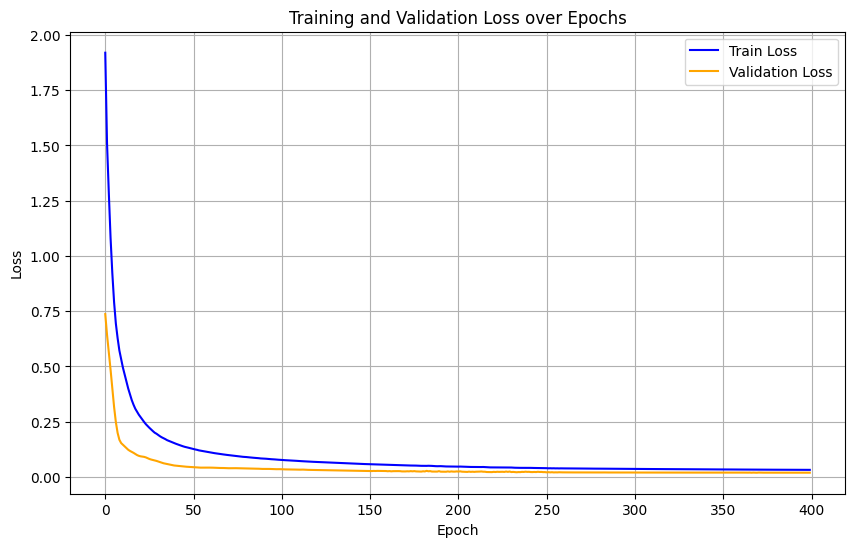

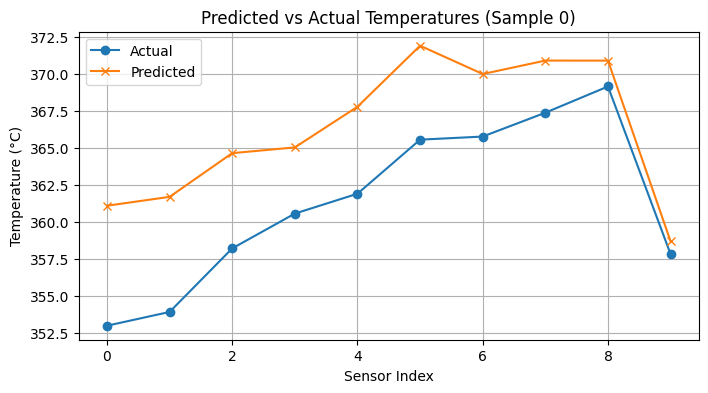

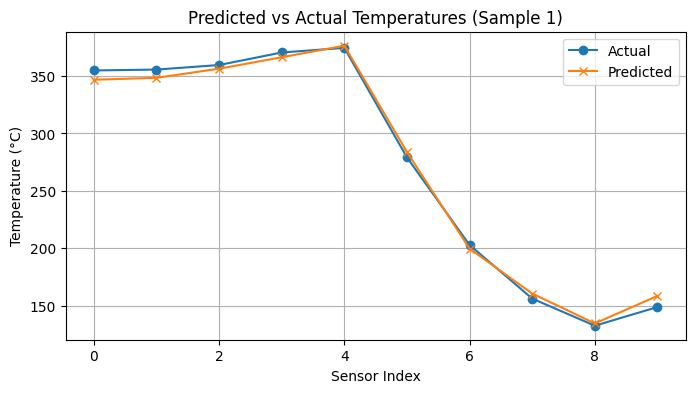

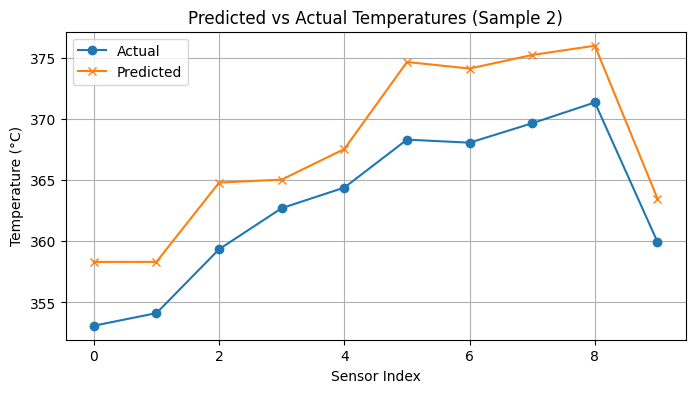

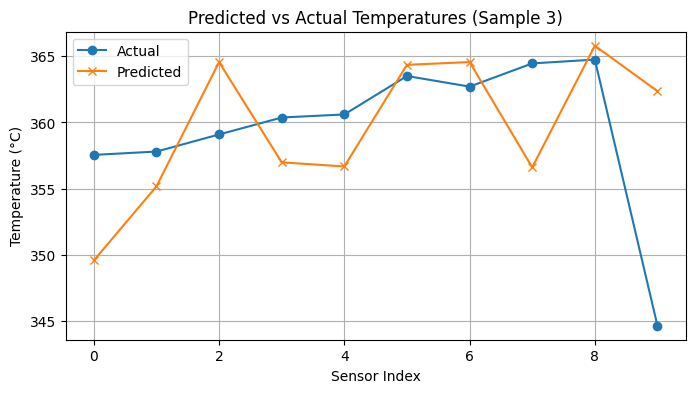

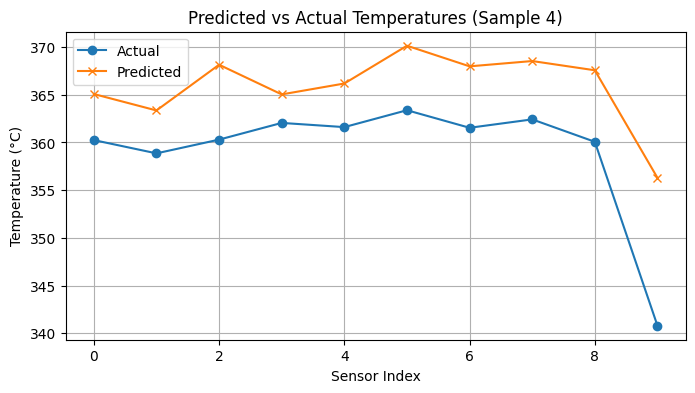

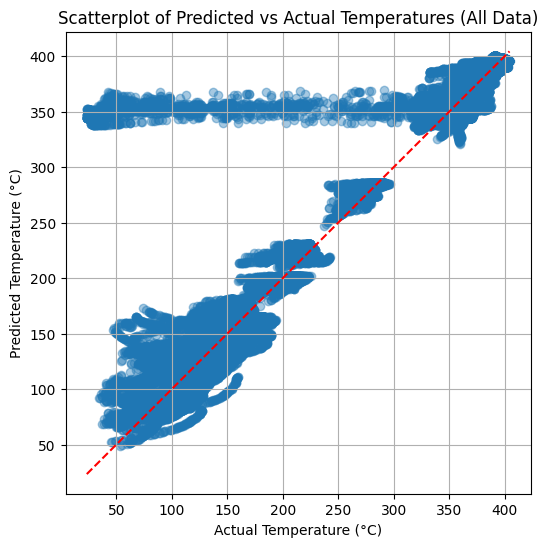

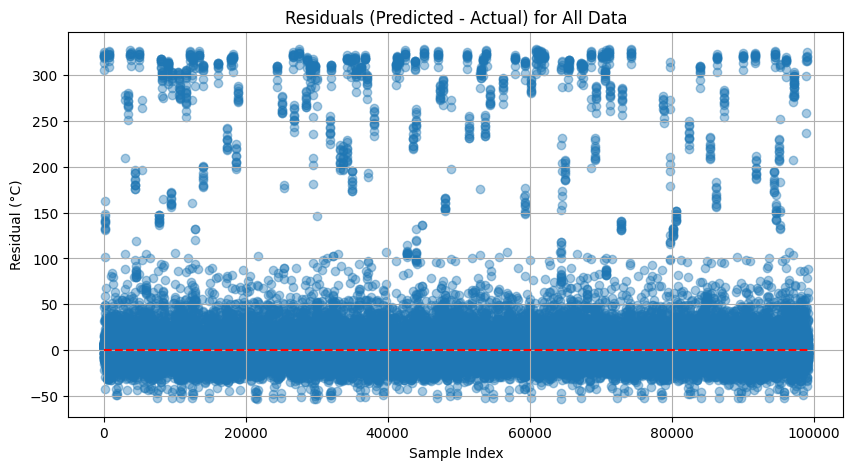

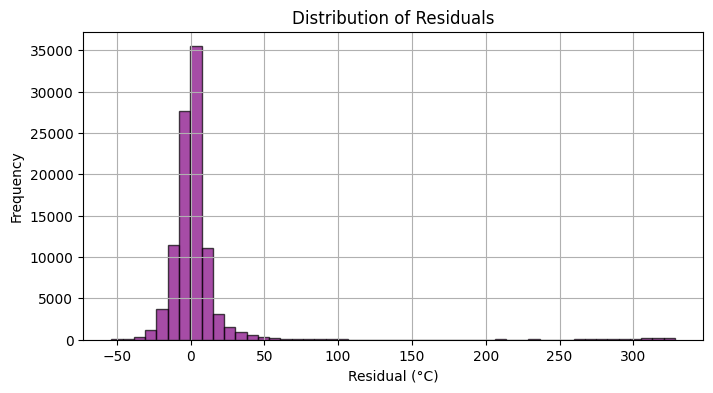

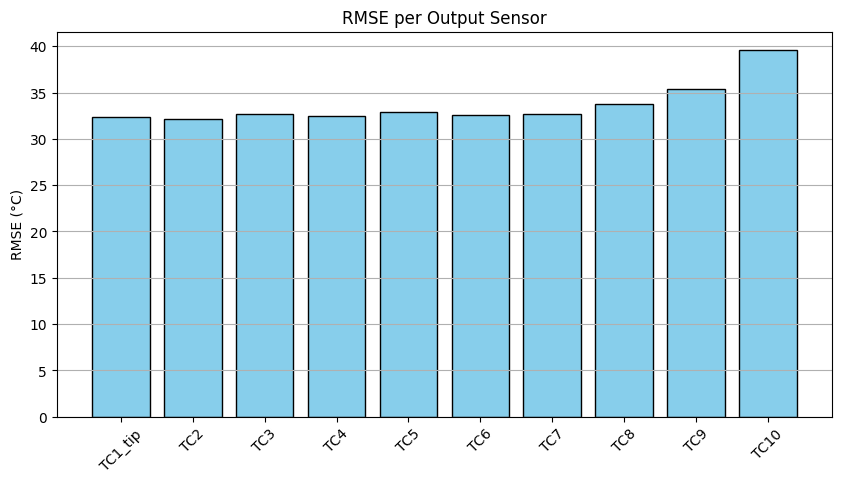

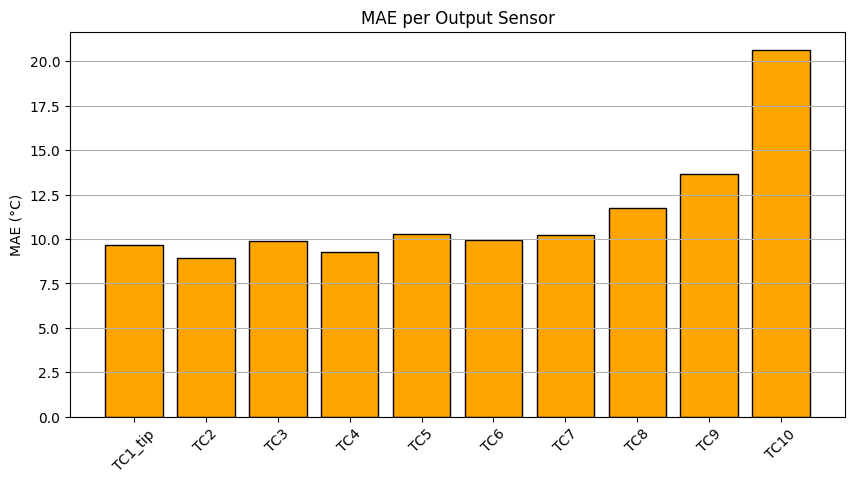

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Predicted vs Actual Temperatures for 5 samples from the test set
num_samples = 5
for idx in range(num_samples):
    plt.figure(figsize=(8, 4))
    plt.plot(y_real[idx], label='Actual', marker='o')
    plt.plot(preds_real[idx], label='Predicted', marker='x')
    plt.title(f'Predicted vs Actual Temperatures (Sample {idx})')
    plt.xlabel('Sensor Index')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()


# Scatterplot

plt.figure(figsize=(6, 6))
plt.scatter(y_real.flatten(), preds_real.flatten(), alpha=0.4)
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], color='red', linestyle='--')
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Scatterplot of Predicted vs Actual Temperatures (All Data)")
plt.grid(True)
plt.axis("equal")
plt.show()

#Residuals (Error) Plot
residuals = preds_real - y_real
plt.figure(figsize=(10, 5))
plt.scatter(range(len(residuals.flatten())), residuals.flatten(), alpha=0.4)
plt.hlines(0, 0, len(residuals.flatten()), colors='red', linestyles='--')
plt.title("Residuals (Predicted - Actual) for All Data")
plt.xlabel("Sample Index")
plt.ylabel("Residual (°C)")
plt.grid(True)
plt.show()

#Residual Distribution Histogram
plt.figure(figsize=(8, 4))
plt.hist(residuals.flatten(), bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Residual (°C)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#Bar Chart: RMSE per Sensor
plt.figure(figsize=(10, 5))
plt.bar(y.columns, rmse, color='skyblue', edgecolor='black')
plt.title("RMSE per Output Sensor")
plt.ylabel("RMSE (°C)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#Bar Chart: MAE per Sensor
plt.figure(figsize=(10, 5))
plt.bar(y.columns, mae, color='orange', edgecolor='black')
plt.title("MAE per Output Sensor")
plt.ylabel("MAE (°C)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()



In [16]:
def check_and_clip_input(input_df, scaler):
    min_vals = scaler.data_min_
    max_vals = scaler.data_max_
    columns = scaler.feature_names_in_
    clipped = False
    for i, col in enumerate(columns):
        val = input_df.iloc[0, i]
        if val < min_vals[i] or val > max_vals[i]:
            print(f"Warning: '{col}' value {val} is out of range [{min_vals[i]}, {max_vals[i]}]. Clipping.")
            input_df.iloc[0, i] = min(max(val, min_vals[i]), max_vals[i])
            clipped = True
    if not clipped:
        print("All input values are within the training range.")
    return input_df

In [ ]:
new_input = [
    [  # Full input vector for inference
        868,     # Time (seconds)
        0.1575,     # Depth (h)
        19400,      # Heat flux (q0)
        3,          # Absorption coefficient (abs)
        0.98        # Surface emissivity (surf)
    ] + [
        306.456710321429,327.074235329552,327.074235329552,327.074235329552,327.074235329552,327.074235329552,327.074235329552,327.074235329552,327.074235329552,327.074235329552
    ]
    
    ]

X_scaler = joblib.load("X_scaler.pkl")
y_scaler = joblib.load("y_scaler.pkl")

# Create DataFrame with correct columns
theory_cols = [f"Theoretical_Temps_{i+1}" for i in range(10)]
input_columns = ["Time", "h", "flux", "abs", "surf"] + theory_cols
new_input_df = pd.DataFrame(new_input, columns=input_columns)

# Clip out-of-range values before scaling
new_input_df = check_and_clip_input(new_input_df, X_scaler)

new_input_scaled = X_scaler.transform(new_input_df)
new_tensor = torch.tensor(new_input_scaled, dtype=torch.float32)

input_size = len(new_input[0])               # Should be 15
output_size = len(y_scaler.scale_)           # Should be 10 if you're predicting TC1–TC10
model = EnhancedThermalNet(input_size, output_size)
model.load_state_dict(torch.load("thermal_model_weights.pth"))
print("Model loaded. First layer weights (sample):", model.net[0].weight[0][:5])
model.eval()

with torch.no_grad():
    pred = model(new_tensor).numpy()
    
real_pred = y_scaler.inverse_transform(pred)
print("\nPredicted Temperatures:", real_pred)

<!-- 360.23	359.53	359.49	359.84	359.06	360.78	358.57	359.13	356.75	333.78 -->